In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import sqrt

# Adding the RelativePosition class here from ExplainPosEncoding without changes

class RelativePosition(nn.Module):

    def __init__(self, scaling_factor, num_buckets, max_distance, num_attn_heads):
        
        super().__init__()
        self.scaling_factor = scaling_factor
        self.num_buckets = num_buckets
        self.max_distance = max_distance
        self.rel_pos_embeddings = nn.Embedding(num_buckets, num_attn_heads)

    # Which each forward pass we provide our "latest" tensor object, updated in the previous backward() pass
    
    def forward(self, seq_len, max_context_len):     # These app. can change depending on the layer - check this.
        
        q_pos = torch.arange(seq_len, dtype=torch.long)               
        k_pos = torch.arange(max_context_len, dtype=torch.long)
        q_pos = q_pos.reshape(q_pos.shape[0], 1)
        rel_pos = k_pos - q_pos
        rel_pos = -rel_pos
        rel_pos = torch.max(rel_pos, torch.zeros_like(rel_pos))
        # We have rel_pos, now we need is_exact matrix and val_if_large matrix
        
        num_token_buckets = self.num_buckets // 2
        is_exact = rel_pos < num_token_buckets

        val_if_large = \
        num_token_buckets + \
        (torch.log(rel_pos.float() / num_token_buckets) / math.log(self.max_distance / num_token_buckets) * (self.num_buckets - num_token_buckets))
        val_if_large = val_if_large.long()
        val_if_large = torch.min(val_if_large, torch.full_like(val_if_large, num_buckets - 1))

        position_bucket_indices = torch.where(is_exact, rel_pos, val_if_large)

        q_k_rel_pos_embeddings = self.rel_pos_embeddings(position_bucket_indices)
        q_k_rel_pos_embeddings = q_k_rel_pos_embeddings.transpose(-1,-2).transpose(0,1)
        q_k_rel_pos_embeddings = q_k_rel_pos_embeddings.unsqueeze(0)

        return q_k_rel_pos_embeddings * self.scaling_factor # This is new in the class.  

# Adding the Memory class here from ExplainMemory without changes

class Memory:

    def __init__(self, mem_dim=64, max_mems=10000):

        self.index = faiss.IndexFlatL2(mem_dim)
        db_filepath = "./numpy.memmap"          
        self.db = np.memmap(db_filepath, mode='w+', dtype=np.float32, shape = (max_mems,2,mem_dim))
        self.db_offset = 0

    def add(self, keys_and_values): 

        keys_and_values = keys_and_values.reshape(-1, 2, mem_dim) 
        keys = keys_and_values[:,0,:]
        keys = keys.numpy()

        self.index.add(keys)
        
        num_added = keys_and_values.shape[0]
        indexes_added = (np.arange(num_added) + self.db_offset)
        self.db[indexes_added] = keys_and_values 
        self.db_offset = self.db_offset + num_added
        self.db.flush() 

    def query(self, queries, top_k=2):  

        b_s = queries.shape[0]
        seq_len = queries.shape[1]

        queries = queries.reshape(-1, mem_dim) 
        queries = queries.numpy()
        
        distances, ids = self.index.search(queries, top_k)
        
        result_keys_and_values = self.db[ids]
        result_keys_and_values = result_keys_and_values.reshape(b_s, seq_len, top_k, 2, mem_dim)
        result_keys_and_values = torch.from_numpy(result_keys_and_values)
        
        return result_keys_and_values
    
    def clear():

        self.index.reset()
        self.db[:] = 0       
        self.db_offset = 0


# Copy in the MHSelfAttn - no changes!

class MHSelfAttn(nn.Module):
    def __init__(self, embed_dim, num_attn_heads):
        super().__init__()
        attn_head_input_dim = embed_dim
        attn_head_output_dim = embed_dim // num_attn_heads

        # Just add self..
        self.Wo = nn.Linear(embed_dim, embed_dim)

        # Just add self..
        self.attn_heads = nn.ModuleList(
            [AttnHead(attn_head_input_dim, attn_head_output_dim) for _ in range(num_attn_heads)]
        )


    def forward(self, input_data):

        
        # Refer to attn_heads with self..
        concatenated_head_context_vectors = torch.cat(
               [attn_head(input_data) for attn_head in self.attn_heads], dim=-1
        )
        # Refer to Wo with self..
        multihead_context_vector = self.Wo(concatenated_head_context_vectors)

        # return it
        return multihead_context_vector


# The rest does not change from 3 - this is the AttenHead Class from 3:

class AttnHead(nn.Module):

    def __init__(self, attn_head_input_dim, attn_head_output_dim):
        super().__init__()

        # Just add self..
        self.Wq = nn.Linear(attn_head_input_dim, attn_head_output_dim, bias=False) 
        self.Wk = nn.Linear(attn_head_input_dim, attn_head_output_dim, bias=False)
        self.Wv = nn.Linear(attn_head_input_dim, attn_head_output_dim, bias=False) 

    def forward(self, input_data):

        # Just add self..
        queries = self.Wq(input_data)     
        keys = self.Wk(input_data)
        values = self.Wv(input_data)

        dim_of_key = keys.size(-1) 
        attn_scores = queries @ keys.transpose(-2,-1)/sqrt(dim_of_key) 
        mask = torch.ones((attn_scores.shape[-1], attn_scores.shape[-1]), dtype=torch.bool).triu(diagonal=1)
        attn_scores = attn_scores.masked_fill(mask, float("-inf"))
        attn_weights = F.softmax(attn_scores, dim = -1)
        head_context_vector = attn_weights@values 
        return head_context_vector  

In [7]:
import numpy as np
#import torch
#import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import datasets

# Copy the training loop, comment out the last line.
# Difference: we isolate the data processsing code in a function, so that we also can load and process (!) the validation dataset

# Addd "train_" to name
train_dataset = datasets.load_dataset("ccdv/arxiv-summarization", split="train", streaming=True)
raw_train_dataset = list(train_dataset.take(10))

# Add the same for validation:
valid_dataset = datasets.load_dataset("ccdv/arxiv-summarization", split="validation", streaming=True)
raw_valid_dataset = list(valid_dataset.take(10))


def clip_article(article, chunk_size):
    remainder = len(article) % chunk_size
    return article[:-remainder]

def process_dataset(dataset, segments=10, seg_len=512):
    chunk_size = segments * seg_len


    raw_articles = [x['article'] for x in raw_dataset] 
    raw_articles = [x for x in raw_articles if len(x) > segments * seg_len]     # Replaced "5120" hardcoded with calculation
    unique_tokens = set(''.join([raw_article for raw_article in raw_articles]))
    raw_articles_as_token_ids = [np.fromstring(raw_article, dtype=np.uint8) for raw_article in raw_articles]



    clipped_raw_articles_as_token_ids = [clip_article(raw_article, chunk_size) for raw_article in raw_articles_as_token_ids]
    clipped_raw_arts_as_t_ids_as_chunks = np.array([article.reshape(-1, chunk_size) for article in clipped_raw_articles_as_token_ids], dtype=object)
    # Slight name change (carry it back if you have time): let's call it processed_dataset
    processed_dataset = torch.tensor(np.concatenate(clipped_raw_arts_as_t_ids_as_chunks), dtype=torch.long)

    return processed_dataset

processed_train_dataset = process_dataset(raw_train_dataset)
processed_valid_dataset = process_dataset(raw_valid_dataset)

    
# Comment this out - we're creating the loader below
#loader = iter(DataLoader(processed_data, batch_size=8, shuffle=True))

/var/folders/xw/rbg9dqnx4h534h57wgqgvpkr0000gn/T/ipykernel_43889/2023826921.py:30: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  raw_articles_as_token_ids = [np.fromstring(raw_article, dtype=np.uint8) for raw_article in raw_articles]


The model below follows the transformer decoder architecture.
Notes:
1. We're not doing the skipconnections yet at this point - when you add that you cannot use Sequential anymore.
2. We are doing post layer normalization here, while in our "core" transformer arch we do pre (so there we have one more norm at the end that we need to add.

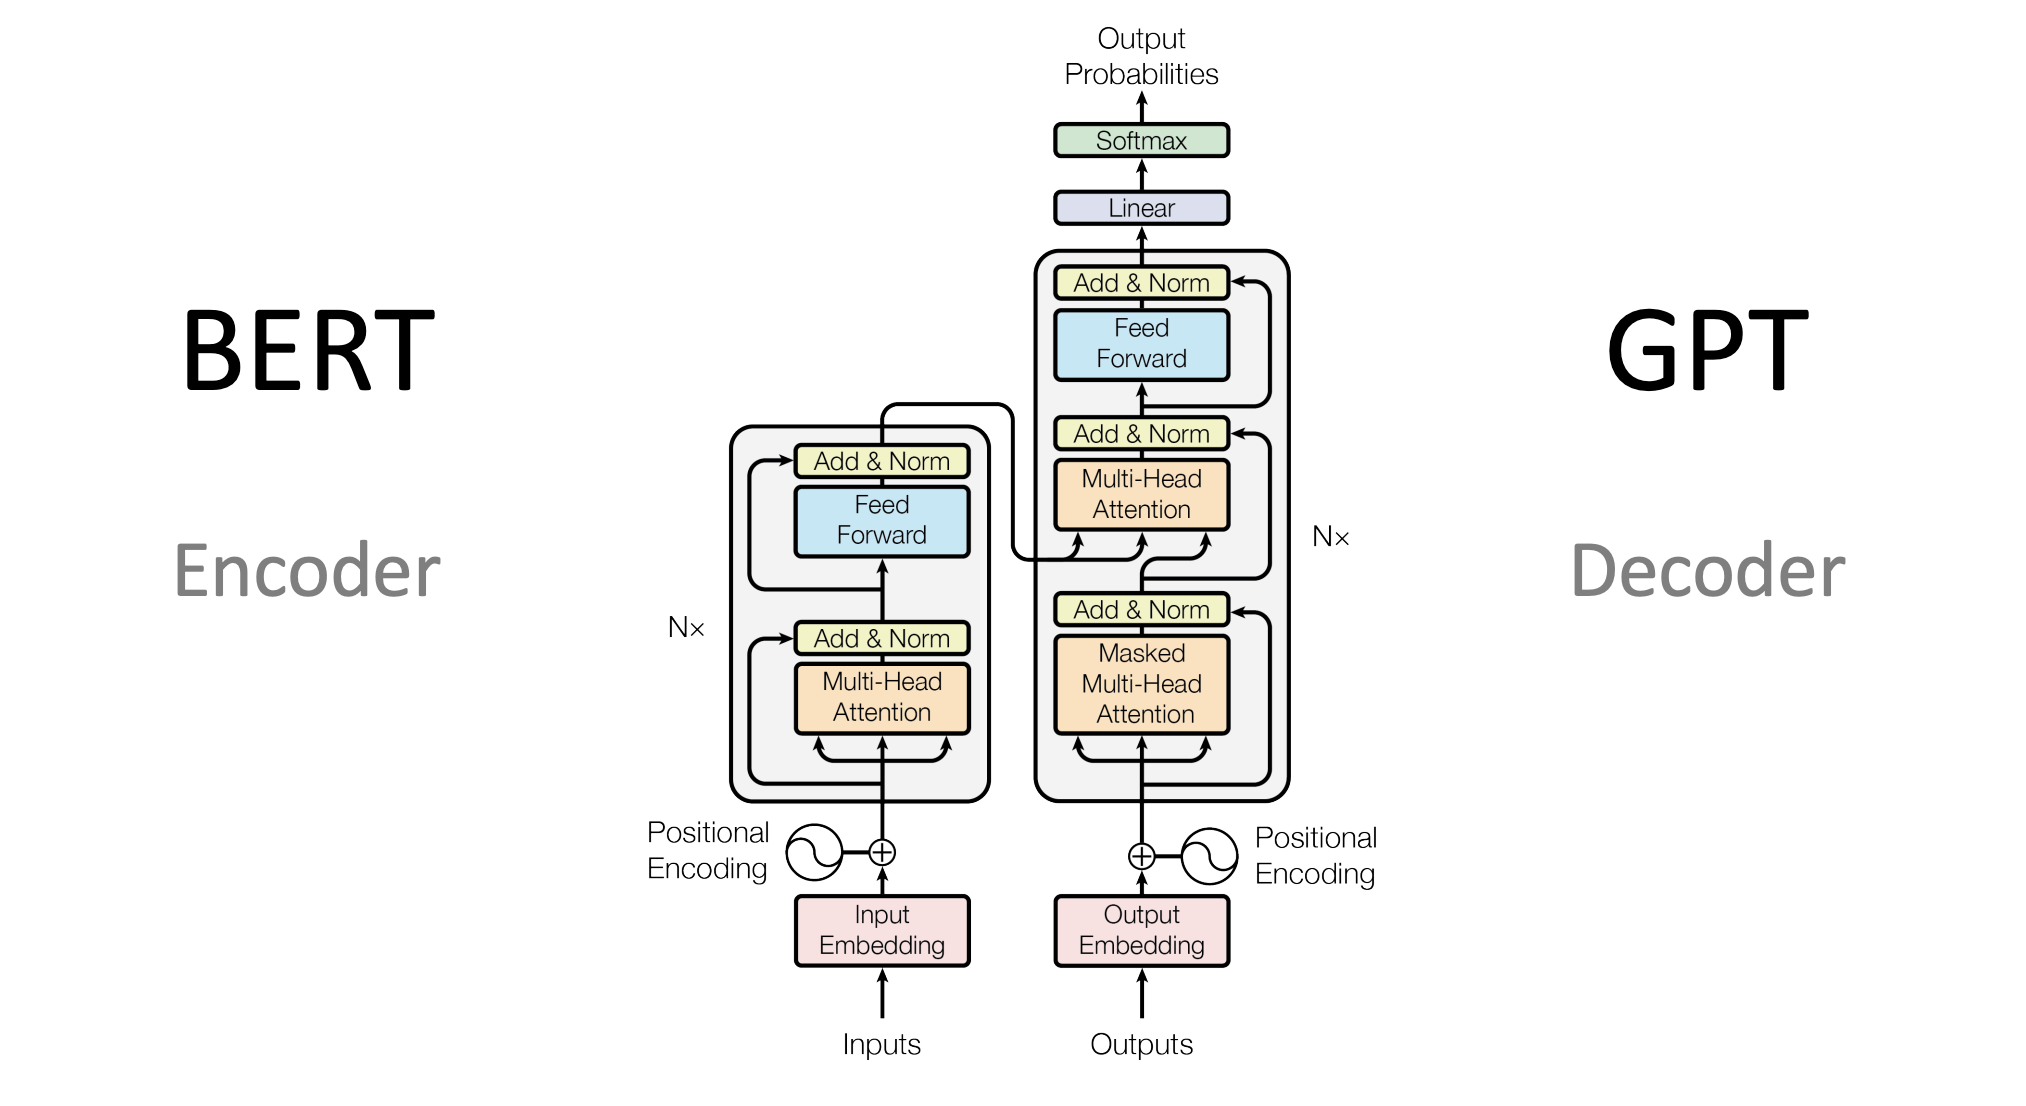

In [2]:
from PIL import Image
Image.open("./transformers.png")

In [14]:
# Add this - we know it's 128
vocab_size = 128
# Add this - let's do 100
intermediate_dim = 100

# Copy these from s4:
seq_len = 512
embed_dim = 256
num_attn_heads = 2
batch_size = 16

# Copied over from training loop, and CHANGE THE MODEL to MHSelfAttn

#model = nn.Sequential(
#    nn.Embedding(128, 16), # (vocab_size, embed_dim)
#    nn.Linear(16, 150),
#    nn.ReLU(),
#    nn.Linear(150,150),
#    nn.ReLU(),
#    nn.Linear(150, 128) # back to vocab_size
#)

model = nn.Sequential(

    nn.Embedding(vocab_size, embed_dim),

    # This is one decoder block
    MHSelfAttn(embed_dim, num_attn_heads),
    nn.LayerNorm(embed_dim),
    nn.Linear(embed_dim, intermediate_dim),
    nn.ReLU(),
    nn.Linear(intermediate_dim, embed_dim),

    # Copy the decoder block x times, here we just o one time
    MHSelfAttn(embed_dim, num_attn_heads),
    nn.LayerNorm(embed_dim),
    nn.Linear(embed_dim, intermediate_dim),
    nn.ReLU(),
    nn.Linear(intermediate_dim, embed_dim),

    # We add the projection layer (to the vocabulary):
    nn.Linear(embed_dim, vocab_size)
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

segments = 10

# Add "train_": and "dataset" vs "data"
train_loader = iter(DataLoader(processed_train_dataset, batch_size=8, shuffle=True))

# Add the validation_loader
valid_loader = iter(DataLoader(processed_valid_dataset, batch_size=8, shuffle=True))

for idx in range(6):

    # Add "train_":
    batch = next(train_loader)  
    seqs, labels = batch[:,:-1], batch[:,1:]
    train_loss = 0

    # Need to move model.train() here since we're switching to eval() now in this loop
    model.train()

    for seqs_segment, labels_segment in zip(seqs.chunk(segments, dim=-1), labels.chunk(segments, dim=-1)): 

        optimizer.zero_grad()
        y_pred = model(seqs_segment) 
        y_pred = y_pred.transpose(2,1) 

        loss = loss_fn(y_pred, labels_segment) 
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    if idx % 2 == 0: 
        # Adding the string to make it clear that this is training loss.
        print("Training loss: ",(train_loss / segments)) 

# New in Stage 5: we are adding the validation loss

    if idx > 0 and idx % 2 == 0:

        batch = next(valid_loader)
        seqs, labels = batch[:,:-1], batch[:,1:]
        valid_loss = 0

        model.eval()

        # Copy from training section and adjusting for evaluation.
        for seqs_segment, labels_segment in zip(seqs.chunk(segments, dim=-1), labels.chunk(segments, dim=-1)): 
            with torch.no_grad(): # We are evaluating, so no need to compute gradients.
                #optimizer.zero_grad() -> Not needed for eval
                y_pred = model(seqs_segment) 
                y_pred = y_pred.transpose(2,1) 

                loss = loss_fn(y_pred, labels_segment) 
                #loss.backward() -> not needed for eval
                #optimizer.step() -> not needed for eval
                valid_loss += loss.item()

        print("Validation loss: ",  (valid_loss/segments))


Training loss:  4.07476840019226
Training loss:  3.299682283401489
Validation loss:  3.2751843214035032
Training loss:  3.2665398836135866
Validation loss:  3.2697110414505004
